In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib.colors import ListedColormap
import itertools

import trueskill
from scipy.stats import norm
from sqlalchemy import select, insert, update, create_engine, Date, and_
from sqlalchemy.orm import Session, aliased

import data
from match_report import (
    read_player_skill_for_team, 
    plot_match_qualities, 
    plot_ridge_skill_distributions, 
    plot_paired_skill_distributions, 
    plot_player_positions_bar,
    get_previous_matches,
    win_probability
    )


In [3]:
sns.set_context("notebook")
sns.set_style("white")

In [4]:
# TODO Better layout for this notebook
# Functions in notebook for:
#   - Previous lineup
#   - Position distribution per player
#   - Get best possible lineup (with best 4 of them?) 

home_club = "Hannover 96"
away_club = "PDC Hannover e.V."
competition = "DBH Bezirksliga 2"
ignore_players = ["Frank Fuhlrott", "Timo Trauslen", "Andreas Schmidt", "Sven Rohde"]

home_players = read_player_skill_for_team(home_club, competition, ignore_players)
away_players = read_player_skill_for_team(away_club, competition)


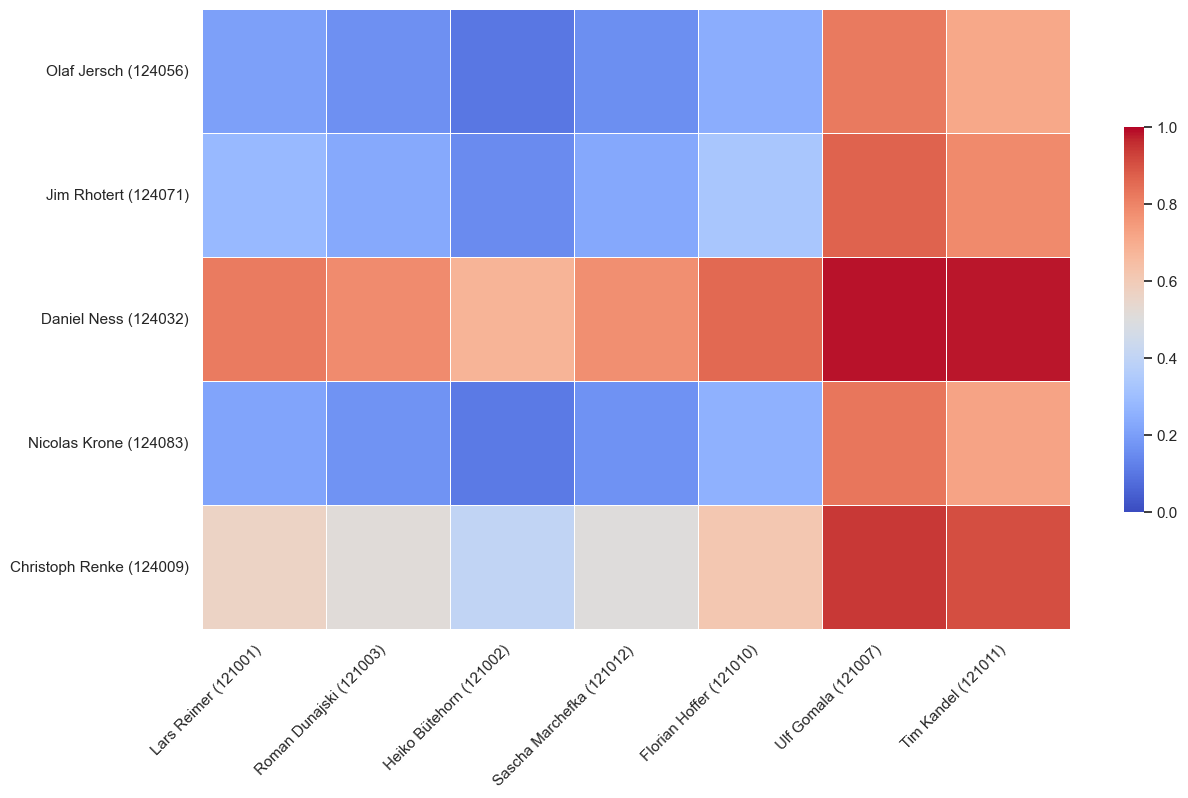

In [5]:
f = plot_match_qualities(home_players, away_players)

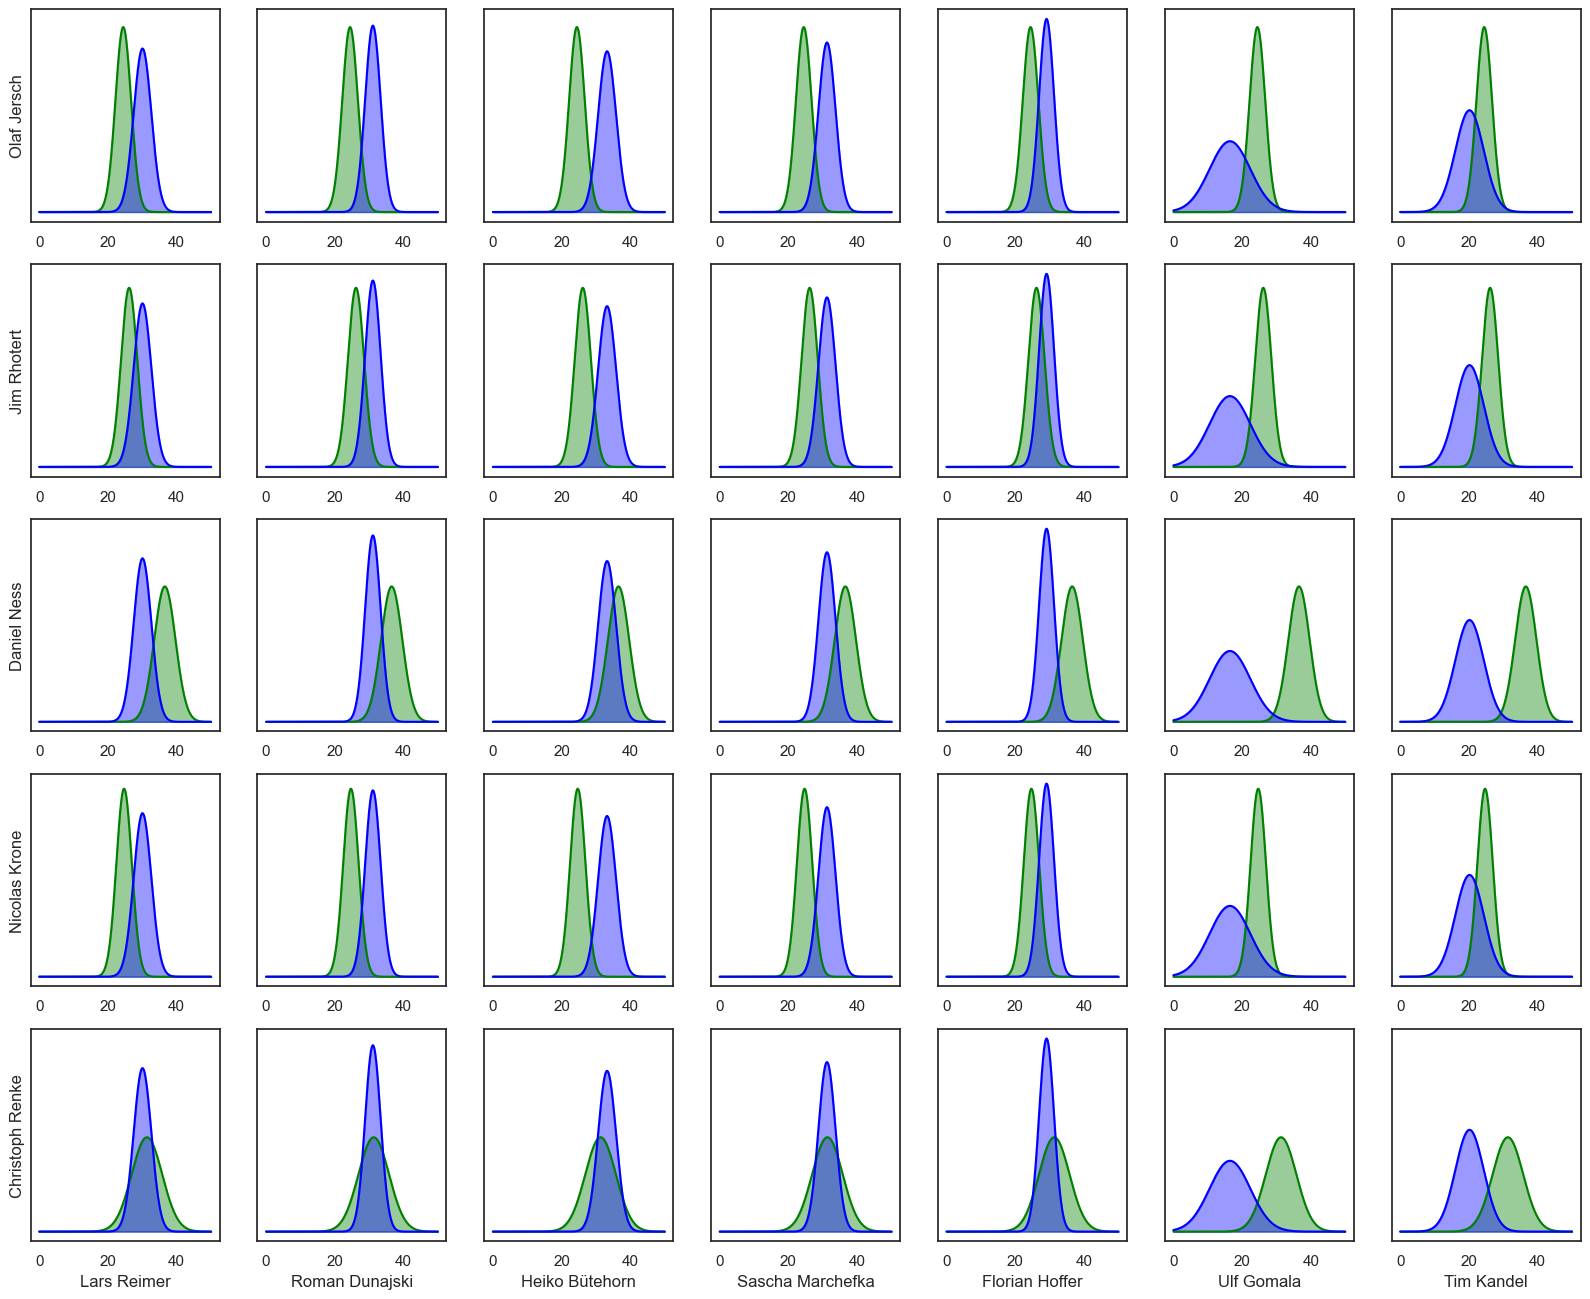

In [6]:
f = plot_paired_skill_distributions(home_players=home_players, away_players=away_players)


s:\Dokumente\Code\ndv-elo\src\match_report.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


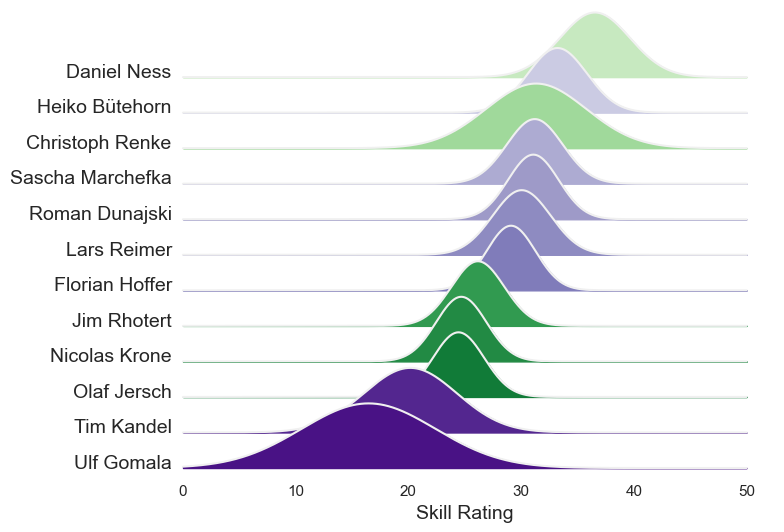

In [7]:
f = plot_ridge_skill_distributions(home_players=home_players, away_players=away_players)


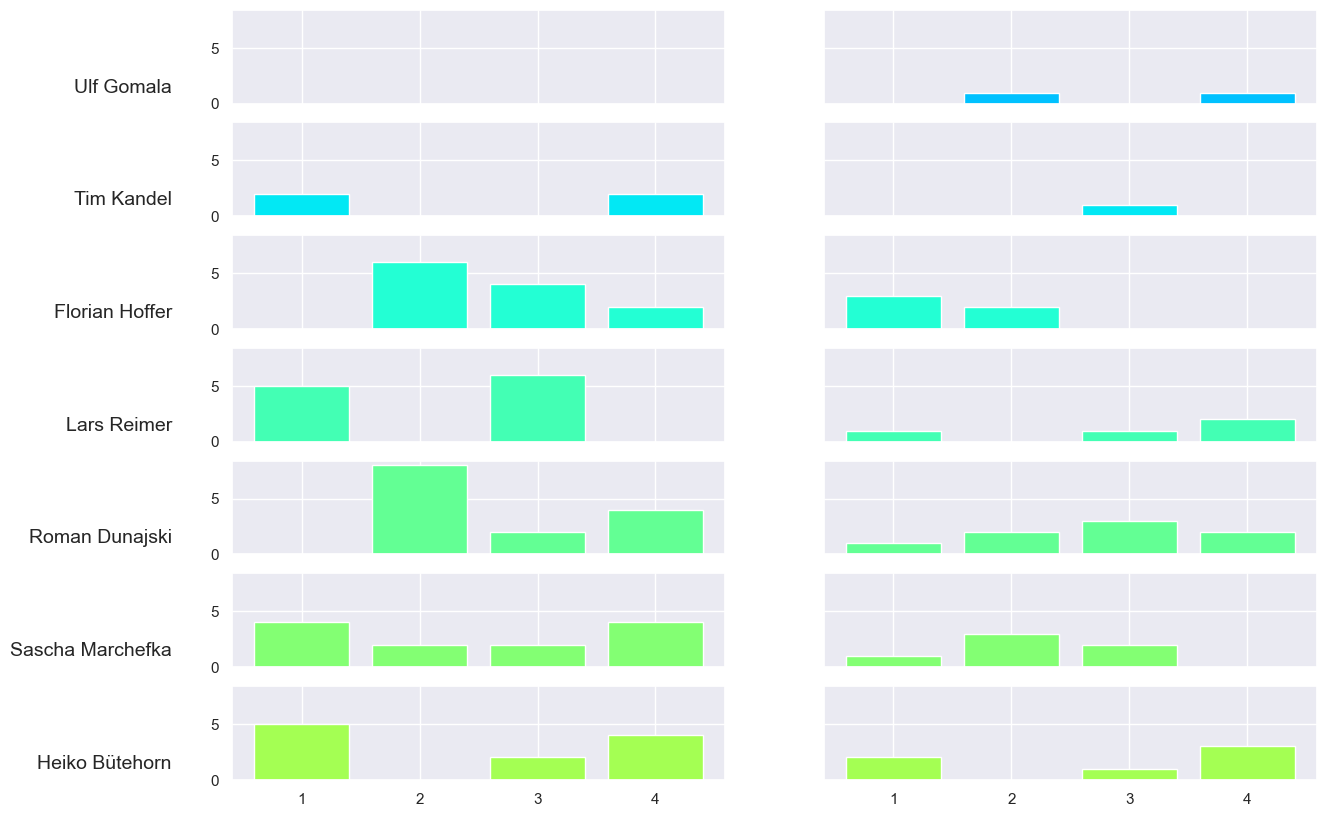

In [8]:
fig = plot_player_positions_bar(away_players)
# TODO Plot player positions as trajectory plot
# https://benalexkeen.com/parallel-coordinates-in-matplotlib/

In [9]:
matches = get_previous_matches(home_players, away_players)
_ = [print(m) for m in matches]

Roman Dunajski 2:3 Daniel Ness @ 2022-10-01 19:00:00, 5:7
Heiko Bütehorn 0:3 Daniel Ness @ 2022-10-01 19:00:00, 5:7
Lars Reimer 0:3 Nicolas Krone @ 2022-10-01 19:00:00, 5:7
Roman Dunajski 0:3 Nicolas Krone @ 2022-10-01 19:00:00, 5:7


In [30]:
def compute_lineup_quality(my_lineup, opponent_lineup):
    ps = []
    for p1, p2 in zip(my_lineup, opponent_lineup):
        wp = win_probability([p1[2]], [p2[2]])
        ps.append(wp)
    hard = np.round(ps)
    return sum(ps), sum(hard)
        

def get_best_lineup(my_players, opponent_lineup):
    # for a given opponent lineup
    # create all possible orderings for my_players
    # consider switching one player
    # compute win probability (soft and hard)
    # argmax over ratings to get best one
    my_players_perms = itertools.permutations(my_players)
    my_players_perms = [perm[:4] for perm in my_players_perms]

    perm_rank_soft = []
    perm_rank_hard = []
    for perm in my_players_perms:
        soft_rank, hard_rank = compute_lineup_quality(perm, opponent_lineup)
        perm_rank_soft.append(soft_rank)
        perm_rank_hard.append(hard_rank)
    print(np.argmax(perm_rank_soft), my_players_perms[np.argmax(perm_rank_soft)])
    print(np.argmax(perm_rank_hard), my_players_perms[np.argmax(perm_rank_hard)])
    print(perm_rank_hard, perm_rank_soft)
    opponent_lineup.insert(0, opponent_lineup.pop())
    # for each permutation we can change each player -> quadruples our permutations
    # shift all permutations as well
    # compute quality for original and changed permutations
    # report on sum of both halfes

get_best_lineup(home_players, sorted(away_players, key=lambda p : p[2].mu, reverse=True)[:4])


81 (('Nicolas Krone', 124083, trueskill.Rating(mu=24.685, sigma=2.237)), ('Jim Rhotert', 124071, trueskill.Rating(mu=26.156, sigma=2.348)), ('Daniel Ness', 124032, trueskill.Rating(mu=36.542, sigma=3.107)), ('Christoph Renke', 124009, trueskill.Rating(mu=31.325, sigma=4.458)))
1 (('Olaf Jersch', 124056, trueskill.Rating(mu=24.440, sigma=2.274)), ('Jim Rhotert', 124071, trueskill.Rating(mu=26.156, sigma=2.348)), ('Daniel Ness', 124032, trueskill.Rating(mu=36.542, sigma=3.107)), ('Christoph Renke', 124009, trueskill.Rating(mu=31.325, sigma=4.458)))
[1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2